# Cell 1: Import Libraries

In [2]:
# Data manipulation
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("✅ Libraries imported successfully")
print(f"TensorFlow version: {tf.__version__}")

✅ Libraries imported successfully
TensorFlow version: 2.18.0


#  Cell 2: Load Dataset

In [3]:
df = pd.read_csv('/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt', 
                 sep=';', 
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 low_memory=False,
                 na_values=['?'])

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (2075259, 8)

First few rows:


,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


# Cell 3: Data Exploration & Info

In [4]:
# Dataset information
print("=== Dataset Information ===")
print(df.info())

print("\n=== Missing Values ===")
print(df.isnull().sum())

print("\n=== Statistical Summary ===")
print(df.describe())

print("\n=== Column Names ===")
print(df.columns.tolist())

=== Dataset Information ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   datetime               datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB
None

=== Missing Values ===
datetime                     0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

=== Statistical Summary ===
                  datetime  Global_active_power  G

# Cell 4: Visualize Missing Data

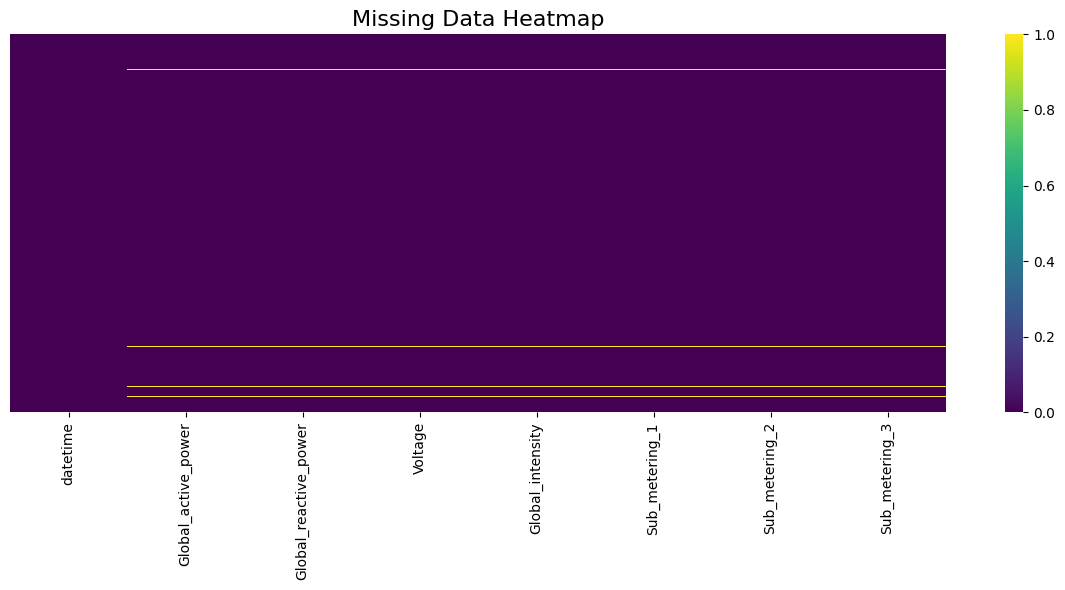


Missing Data Percentage:
Global_active_power      1.251844
Global_reactive_power    1.251844
Voltage                  1.251844
Global_intensity         1.251844
Sub_metering_1           1.251844
Sub_metering_2           1.251844
Sub_metering_3           1.251844
dtype: float64


In [5]:
# Visualize missing data
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
plt.title('Missing Data Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

# Missing percentage
missing_pct = (df.isnull().sum() / len(df)) * 100
print("\nMissing Data Percentage:")
print(missing_pct[missing_pct > 0])

# Cell 5: Data Cleaning

In [6]:
# Handle missing values
print(f"Rows before cleaning: {len(df)}")

# Drop rows with missing values (since they're less than 2%)
df = df.dropna()

# Convert numeric columns
numeric_columns = ['Global_active_power', 'Global_reactive_power', 'Voltage', 
                   'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna()

print(f"Rows after cleaning: {len(df)}")
print(f"Data loss: {((2049280 - len(df)) / 2049280 * 100):.2f}%")

df.head()

Rows before cleaning: 2075259
Rows after cleaning: 2049280
Data loss: 0.00%


,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


# Cell 6: Feature Engineering - Time Features

In [7]:
# Extract time-based features
df['hour'] = df['datetime'].dt.hour
df['day'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.month
df['day_of_week'] = df['datetime'].dt.dayofweek
df['quarter'] = df['datetime'].dt.quarter
df['year'] = df['datetime'].dt.year

# Create cyclical features for hour (to maintain continuity)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Create cyclical features for day_of_week
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# Weekend indicator
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

# Time of day categories
def categorize_time(hour):
    if 0 <= hour < 6:
        return 0  # Night
    elif 6 <= hour < 12:
        return 1  # Morning
    elif 12 <= hour < 18:
        return 2  # Afternoon
    else:
        return 3  # Evening

df['time_of_day'] = df['hour'].apply(categorize_time)

print("✅ Time-based features created")
df[['datetime', 'hour', 'day', 'month', 'is_weekend', 'time_of_day']].head(10)

✅ Time-based features created


,datetime,hour,day,month,is_weekend,time_of_day
0,2006-12-16 17:24:00,17,16,12,1,2
1,2006-12-16 17:25:00,17,16,12,1,2
2,2006-12-16 17:26:00,17,16,12,1,2
3,2006-12-16 17:27:00,17,16,12,1,2
4,2006-12-16 17:28:00,17,16,12,1,2
5,2006-12-16 17:29:00,17,16,12,1,2
6,2006-12-16 17:30:00,17,16,12,1,2
7,2006-12-16 17:31:00,17,16,12,1,2
8,2006-12-16 17:32:00,17,16,12,1,2
9,2006-12-16 17:33:00,17,16,12,1,2


# Cell 7: Feature Engineering - Lag Features

In [ ]:
# Create lag features (previous consumption values)
# These help the model understand patterns over time

# Sort by datetime to ensure proper lag calculation
df = df.sort_values('datetime')

# Lag features - previous hours
for lag in [1, 2, 3, 6, 12, 24]:
    df[f'lag_{lag}h'] = df['Global_active_power'].shift(lag)

# Rolling statistics
df['rolling_mean_3h'] = df['Global_active_power'].rolling(window=3).mean()
df['rolling_mean_6h'] = df['Global_active_power'].rolling(window=6).mean()
df['rolling_std_6h'] = df['Global_active_power'].rolling(window=6).std()

# Drop rows with NaN created by lag and rolling features
df = df.dropna()

print(f"✅ Lag features created")
print(f"Final dataset shape: {df.shape}")
df.head()

✅ Lag features created
Final dataset shape: (2049256, 29)


,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,day,...,time_of_day,lag_1h,lag_2h,lag_3h,lag_6h,lag_12h,lag_24h,rolling_mean_3h,rolling_mean_6h,rolling_std_6h
24,2006-12-16 17:48:00,4.474,0.0,234.96,19.4,0.0,0.0,17.0,17,16,...,2,5.174,7.026,7.706,3.266,5.224,4.216,5.558000,5.667000,1.515384
25,2006-12-16 17:49:00,3.248,0.0,236.66,13.6,0.0,0.0,17.0,17,16,...,2,4.474,5.174,7.026,3.728,5.268,5.360,4.298667,5.587000,1.645320
26,2006-12-16 17:50:00,3.236,0.0,235.84,13.6,0.0,0.0,17.0,17,16,...,2,3.248,4.474,5.174,5.894,4.054,5.374,3.652667,5.144000,1.886311
27,2006-12-16 17:51:00,3.228,0.0,235.60,13.6,0.0,0.0,17.0,17,16,...,2,3.236,3.248,4.474,7.706,3.384,5.388,3.237333,4.397667,1.520262
28,2006-12-16 17:52:00,3.258,0.0,235.49,13.8,0.0,0.0,17.0,17,16,...,2,3.228,3.236,3.248,7.026,3.270,3.666,3.240667,3.769667,0.846213


#  Cell 8: Exploratory Data Analysis - Consumption Patterns

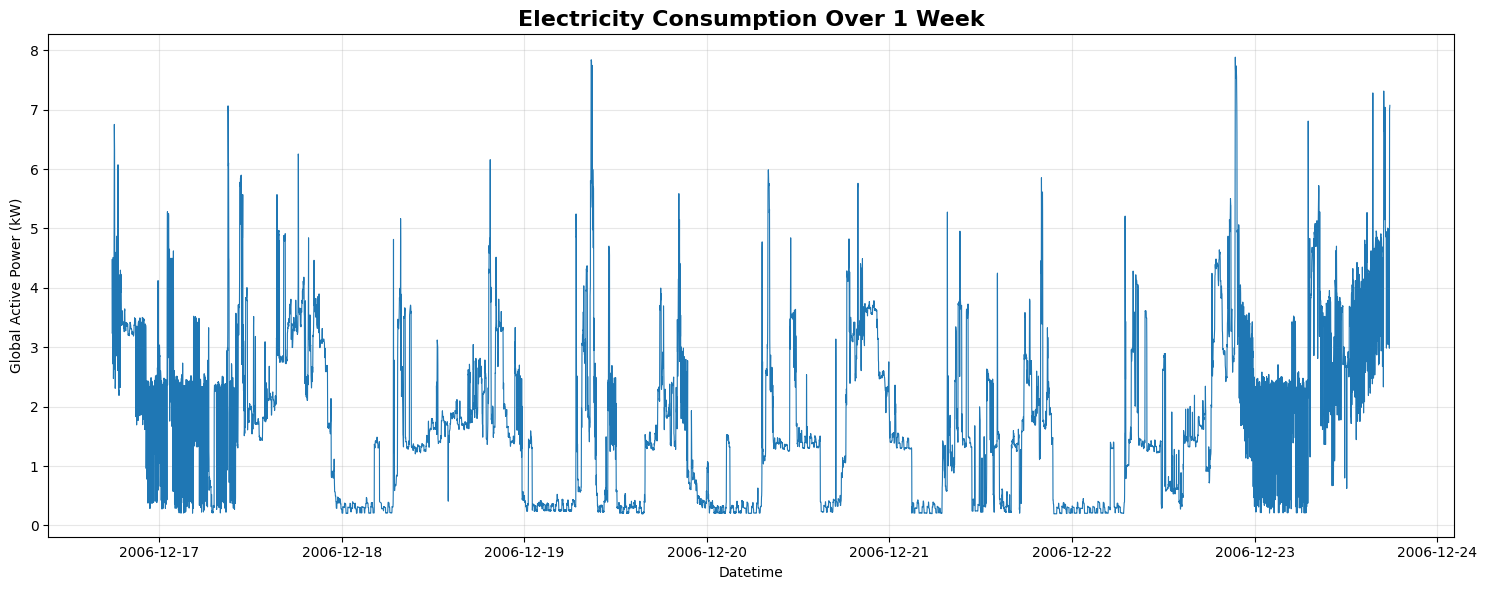

In [9]:
# Plot electricity consumption over time
plt.figure(figsize=(15, 6))

# Sample data for visualization (plot 1 week)
sample = df[df['datetime'] < df['datetime'].min() + pd.Timedelta(days=7)]

plt.plot(sample['datetime'], sample['Global_active_power'], linewidth=0.8)
plt.title('Electricity Consumption Over 1 Week', fontsize=16, fontweight='bold')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power (kW)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Cell 9: EDA - Hourly & Daily Patterns

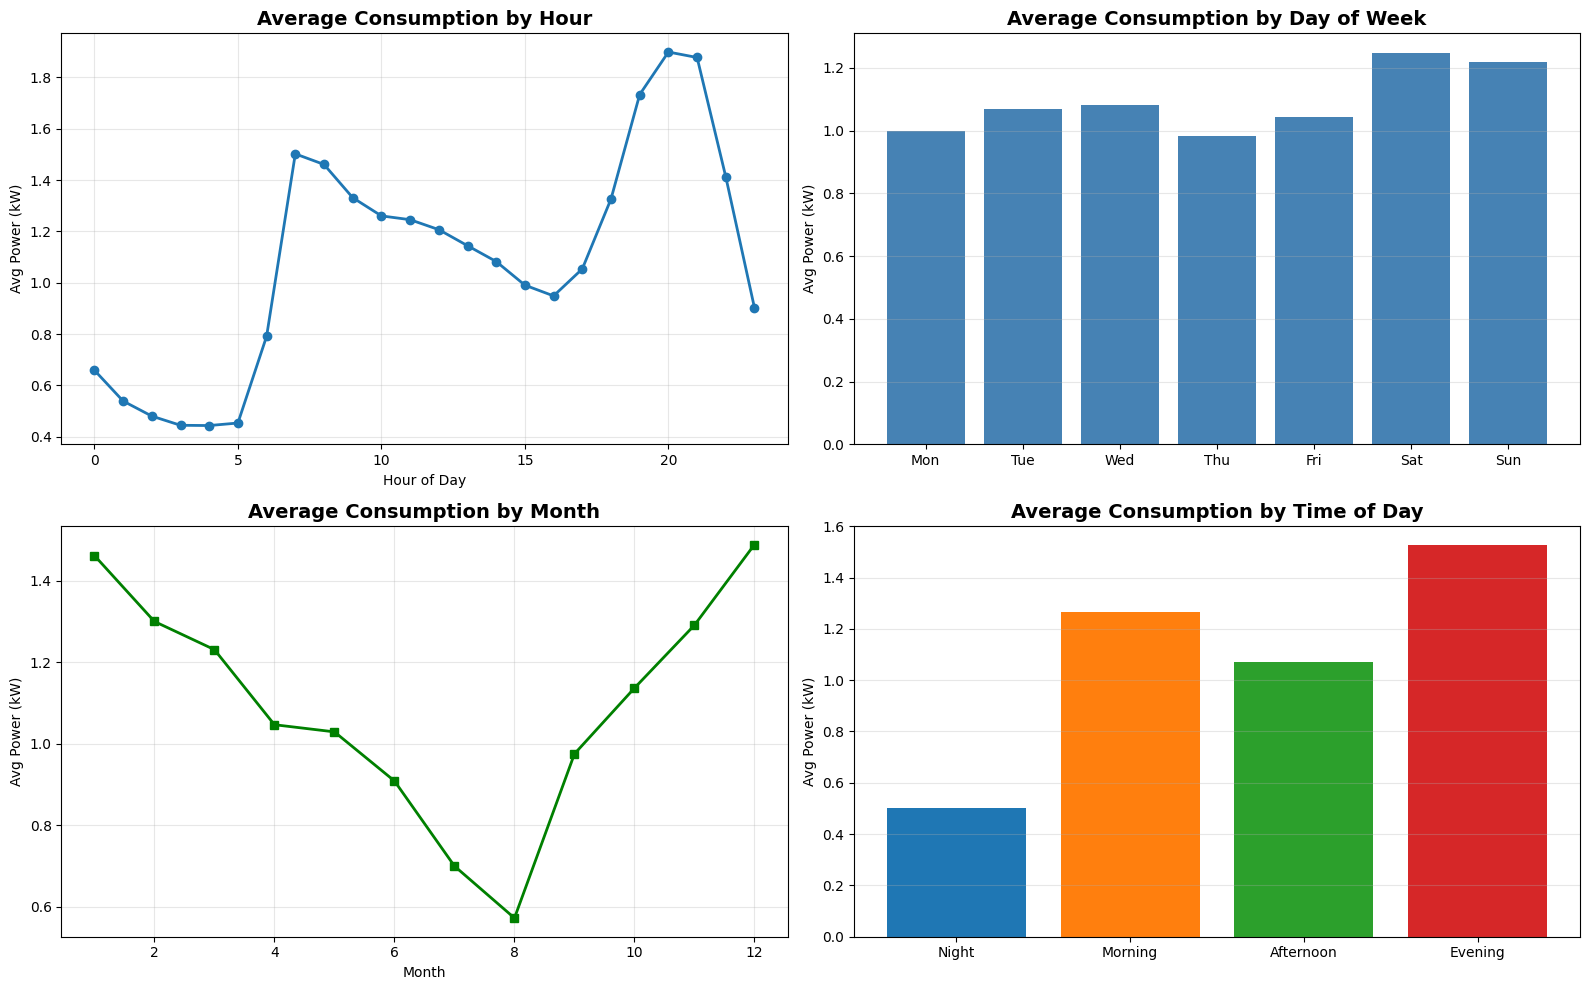

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Hourly pattern
hourly_avg = df.groupby('hour')['Global_active_power'].mean()
axes[0, 0].plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2)
axes[0, 0].set_title('Average Consumption by Hour', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Avg Power (kW)')
axes[0, 0].grid(True, alpha=0.3)

# Day of week pattern
day_avg = df.groupby('day_of_week')['Global_active_power'].mean()
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0, 1].bar(range(7), day_avg.values, color='steelblue')
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(day_names)
axes[0, 1].set_title('Average Consumption by Day of Week', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Avg Power (kW)')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Monthly pattern
monthly_avg = df.groupby('month')['Global_active_power'].mean()
axes[1, 0].plot(monthly_avg.index, monthly_avg.values, marker='s', linewidth=2, color='green')
axes[1, 0].set_title('Average Consumption by Month', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Avg Power (kW)')
axes[1, 0].grid(True, alpha=0.3)

# Time of day pattern
time_avg = df.groupby('time_of_day')['Global_active_power'].mean()
time_labels = ['Night', 'Morning', 'Afternoon', 'Evening']
axes[1, 1].bar(range(4), time_avg.values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[1, 1].set_xticks(range(4))
axes[1, 1].set_xticklabels(time_labels)
axes[1, 1].set_title('Average Consumption by Time of Day', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Avg Power (kW)')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Cell 10: EDA - Correlation Analysis

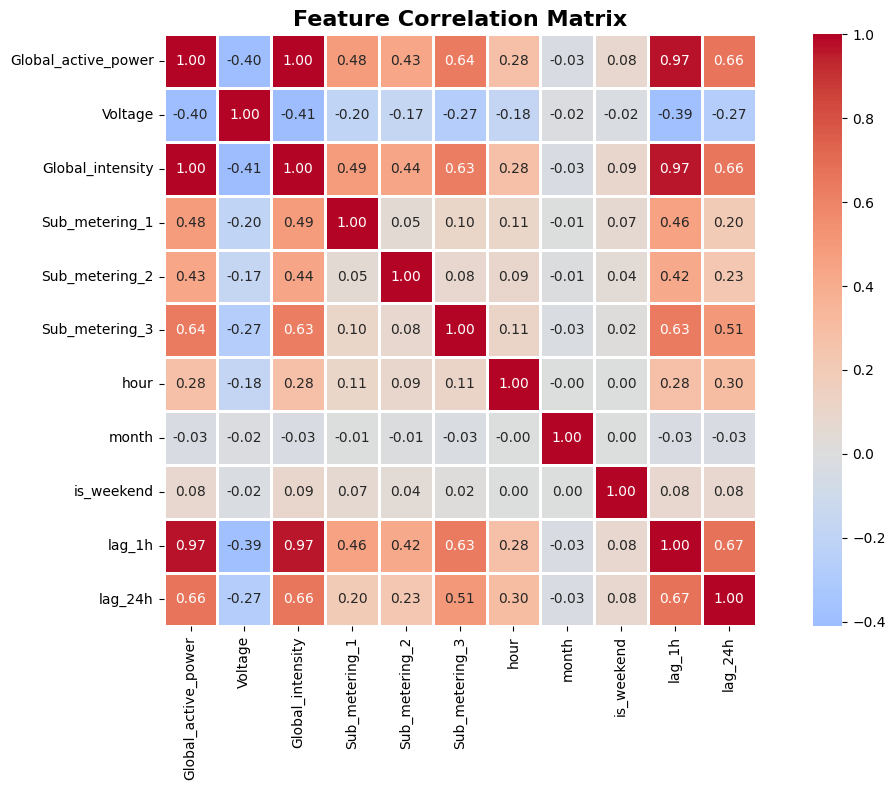


=== Top Features Correlated with Consumption ===
Global_active_power    1.000000
Global_intensity       0.998889
lag_1h                 0.968027
lag_24h                0.664798
Sub_metering_3         0.638559
Sub_metering_1         0.484443
Sub_metering_2         0.434603
hour                   0.281592
is_weekend             0.084579
month                 -0.032720
Voltage               -0.399717
Name: Global_active_power, dtype: float64


In [11]:
# Select relevant features for correlation
corr_features = ['Global_active_power', 'Voltage', 'Global_intensity', 
                 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
                 'hour', 'month', 'is_weekend', 'lag_1h', 'lag_24h']

# Correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = df[corr_features].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Top correlations with target
target_corr = correlation_matrix['Global_active_power'].sort_values(ascending=False)
print("\n=== Top Features Correlated with Consumption ===")
print(target_corr)

# Cell 11: Prepare Data for Neural Network

In [12]:
# Select features for the model
feature_columns = [
    'Voltage', 'Global_intensity',
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
    'hour', 'day', 'month', 'day_of_week', 'quarter',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'is_weekend', 'time_of_day',
    'lag_1h', 'lag_2h', 'lag_3h', 'lag_6h', 'lag_12h', 'lag_24h',
    'rolling_mean_3h', 'rolling_mean_6h', 'rolling_std_6h'
]

# Target variable
target_column = 'Global_active_power'

# Create X and y
X = df[feature_columns].values
y = df[target_column].values

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature names ({len(feature_columns)}):")
for i, col in enumerate(feature_columns, 1):
    print(f"{i}. {col}")

Features shape: (2049256, 25)
Target shape: (2049256,)

Feature names (25):
1. Voltage
2. Global_intensity
3. Sub_metering_1
4. Sub_metering_2
5. Sub_metering_3
6. hour
7. day
8. month
9. day_of_week
10. quarter
11. hour_sin
12. hour_cos
13. day_sin
14. day_cos
15. is_weekend
16. time_of_day
17. lag_1h
18. lag_2h
19. lag_3h
20. lag_6h
21. lag_12h
22. lag_24h
23. rolling_mean_3h
24. rolling_mean_6h
25. rolling_std_6h


# Cell 12: Train-Test Split

In [13]:
# Split data: 80% train, 20% test
# Use time-based split to avoid data leakage
split_idx = int(len(X) * 0.8)

X_train = X[:split_idx]
X_test = X[split_idx:]
y_train = y[:split_idx]
y_test = y[split_idx:]

print("=== Data Split ===")
print(f"Training samples: {len(X_train):,}")
print(f"Testing samples: {len(X_test):,}")
print(f"\nTraining period: {df['datetime'].iloc[0]} to {df['datetime'].iloc[split_idx-1]}")
print(f"Testing period: {df['datetime'].iloc[split_idx]} to {df['datetime'].iloc[-1]}")

=== Data Split ===
Training samples: 1,639,404
Testing samples: 409,852

Training period: 2006-12-16 17:48:00 to 2010-02-05 04:32:00
Testing period: 2010-02-05 04:33:00 to 2010-11-26 21:02:00


# Cell 13: Feature Scaling

In [14]:
# Standardize features (important for neural networks)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

print("✅ Features scaled using StandardScaler")
print(f"\nOriginal y range: [{y_train.min():.2f}, {y_train.max():.2f}]")
print(f"Scaled y range: [{y_train_scaled.min():.2f}, {y_train_scaled.max():.2f}]")

✅ Features scaled using StandardScaler

Original y range: [0.08, 11.12]
Scaled y range: [-0.95, 9.16]


#  Cell 14: Build Neural Network Model

In [15]:
# Build the neural network
def create_model(input_dim):
    model = Sequential([
        # Input layer + First hidden layer
        Dense(128, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.3),
        
        # Second hidden layer
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        # Third hidden layer
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        # Fourth hidden layer
        Dense(16, activation='relu'),
        
        # Output layer
        Dense(1)  # Single output for regression
    ])
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Create model
model = create_model(X_train_scaled.shape[1])

# Display model architecture
print("=== Neural Network Architecture ===")
model.summary()

I0000 00:00:1765721731.136702      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


=== Neural Network Architecture ===


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,105 (59.00 KB)

 Trainable params: 14,657 (57.25 KB)

 Non-trainable params: 448 (1.75 KB)

#  Cell 15: Train the Model

In [16]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

# Train the model
print("🚀 Starting model training...")
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_split=0.2,
    epochs=100,
    batch_size=128,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\n✅ Model training completed!")

🚀 Starting model training...
Epoch 1/100


I0000 00:00:1765721735.100362     115 service.cc:148] XLA service 0x7e71a4023550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765721735.100712     115 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765721735.494319     115 cuda_dnn.cc:529] Loaded cuDNN version 90300


   64/10247 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 1.2512 - mae: 0.7970

I0000 00:00:1765721737.865120     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10247/10247 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - loss: 0.1025 - mae: 0.1879 - val_loss: 0.0115 - val_mae: 0.0616 - learning_rate: 0.0010
Epoch 2/100
10247/10247 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.0181 - mae: 0.0794 - val_loss: 0.0087 - val_mae: 0.0515 - learning_rate: 0.0010
Epoch 3/100
10247/10247 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 0.0118 - mae: 0.0655 - val_loss: 0.0122 - val_mae: 0.0537 - learning_rate: 0.0010
Epoch 4/100
10247/10247 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.0097 - mae: 0.0600 - val_loss: 0.0078 - val_mae: 0.0397 - learning_rate: 0.0010
Epoch 5/100
10247/10247 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.0086 - mae: 0.0570 - val_loss: 0.0082 - val_mae: 0.0438 - learning_rate: 0.0010
Epoch 6/100
10247/10247 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.0078 - mae: 0.0547 - val_loss: 0.0076 - val_mae: 0.0376 - learning_rate: 0.0010
Epoch 7/100
10247/10247 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 0.0073 - mae: 0.0531 - val_loss: 0.0080 - val_mae: 0.0384 

# Cell 16: Plot Training History

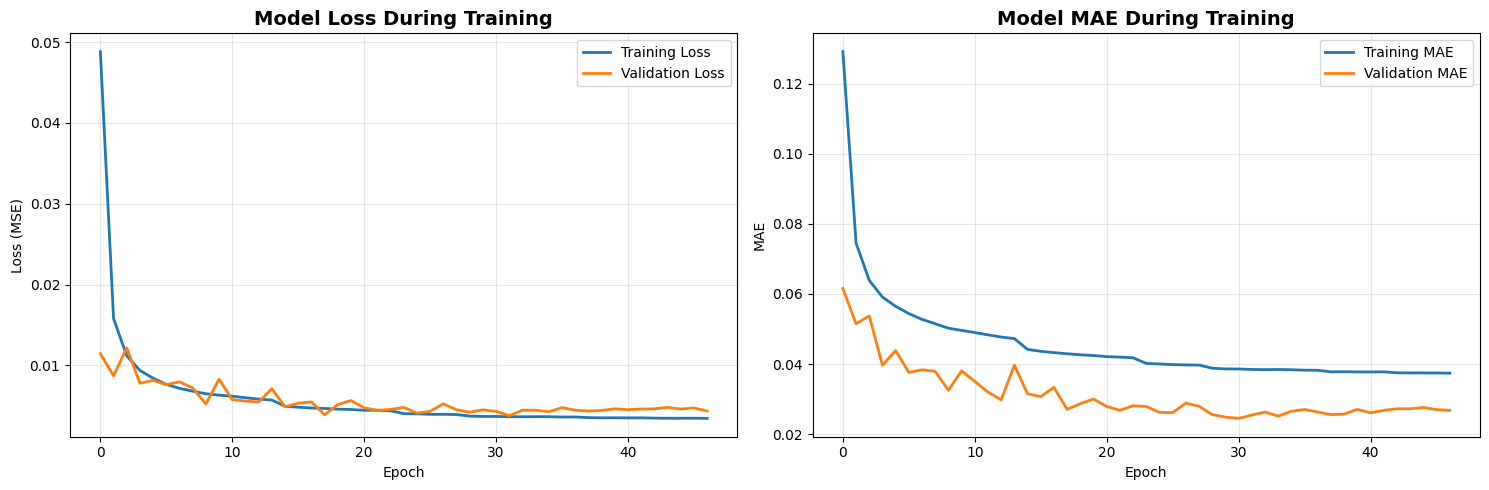

In [23]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model Loss During Training', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_title('Model MAE During Training', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#  Cell 17: Make Predictions

In [18]:
# Make predictions on test set
y_pred_scaled = model.predict(X_test_scaled, verbose=0)

# Inverse transform to get actual values
y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()

print("✅ Predictions generated")
print(f"\nPrediction range: [{y_pred.min():.2f}, {y_pred.max():.2f}] kW")
print(f"Actual range: [{y_test.min():.2f}, {y_test.max():.2f}] kW")

✅ Predictions generated

Prediction range: [0.18, 11.33] kW
Actual range: [0.14, 9.72] kW


# Cell 18: Evaluate Model Performance

In [19]:
# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("=" * 50)
print("📊 MODEL PERFORMANCE METRICS")
print("=" * 50)
print(f"Mean Squared Error (MSE):  {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f} kW")
print(f"Mean Absolute Error (MAE): {mae:.4f} kW")
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")
print("=" * 50)

# Interpretation
print("\n📝 Interpretation:")
print(f"- The model's predictions are off by an average of {mae:.2f} kW")
print(f"- The model explains {r2*100:.2f}% of the variance in electricity consumption")
print(f"- Average percentage error: {mape:.2f}%")

📊 MODEL PERFORMANCE METRICS
Mean Squared Error (MSE):  0.0029
Root Mean Squared Error (RMSE): 0.0538 kW
Mean Absolute Error (MAE): 0.0241 kW
R² Score: 0.9964
MAPE: 3.40%

📝 Interpretation:
- The model's predictions are off by an average of 0.02 kW
- The model explains 99.64% of the variance in electricity consumption
- Average percentage error: 3.40%


# Cell 19: Visualize Predictions vs Actual

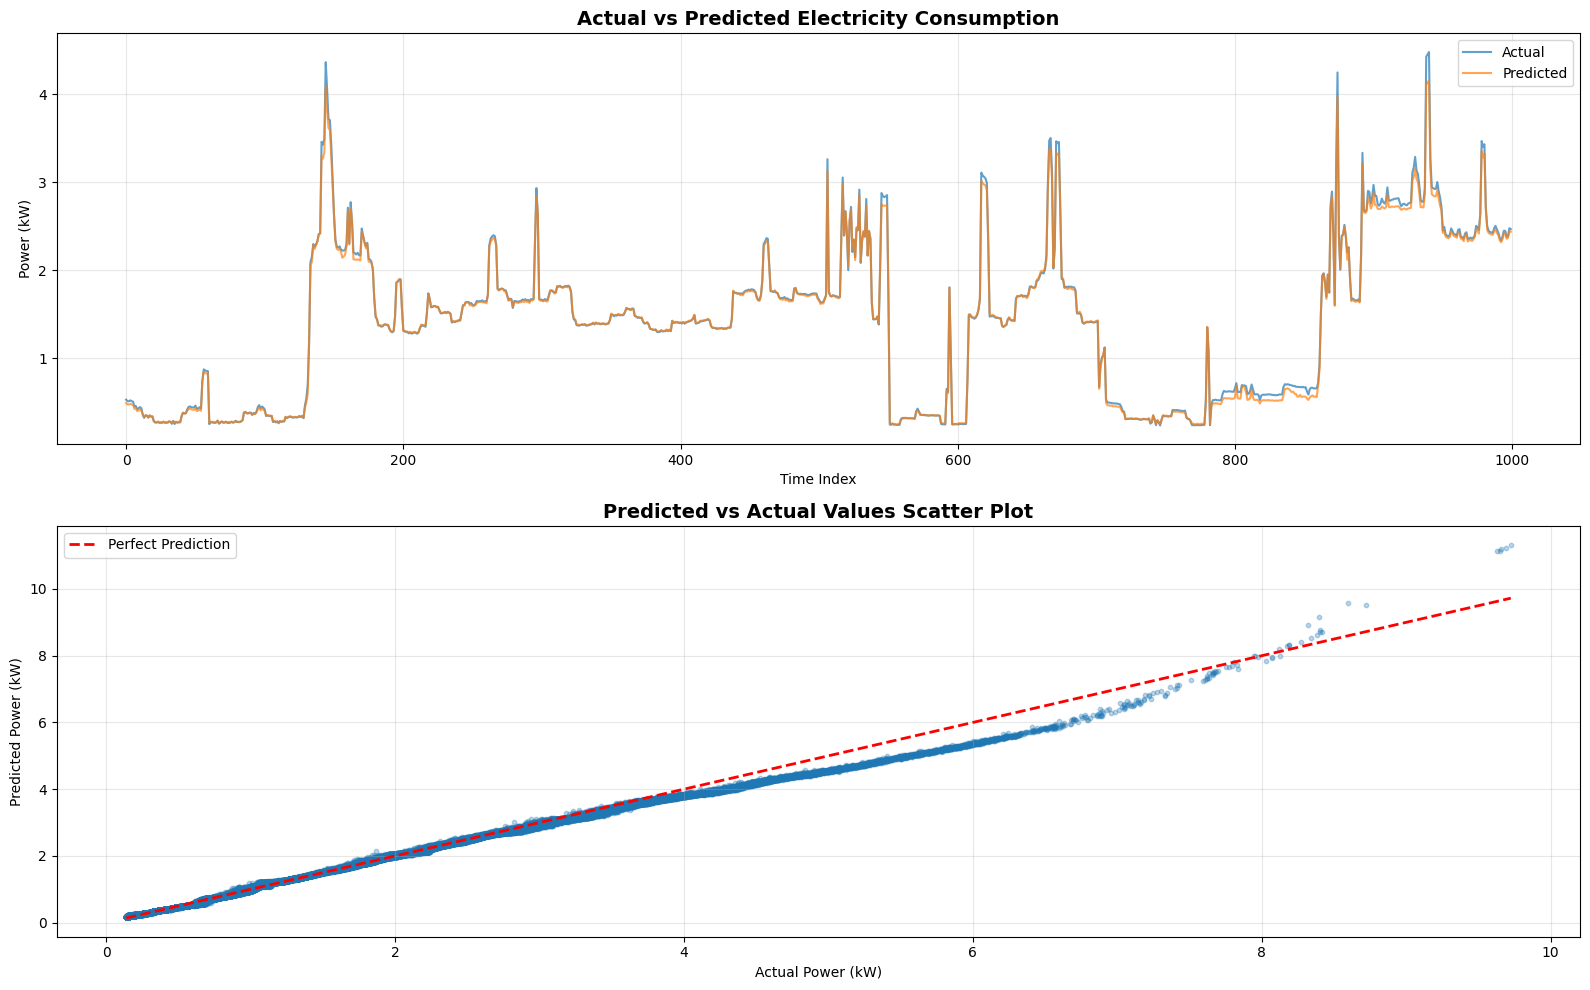

In [20]:
# Plot predictions vs actual values
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: Time series comparison (first 1000 points)
sample_size = 1000
axes[0].plot(y_test[:sample_size], label='Actual', alpha=0.7, linewidth=1.5)
axes[0].plot(y_pred[:sample_size], label='Predicted', alpha=0.7, linewidth=1.5)
axes[0].set_title('Actual vs Predicted Electricity Consumption', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time Index')
axes[0].set_ylabel('Power (kW)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Scatter plot
axes[1].scatter(y_test, y_pred, alpha=0.3, s=10)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_title('Predicted vs Actual Values Scatter Plot', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Actual Power (kW)')
axes[1].set_ylabel('Predicted Power (kW)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Cell 20: Residual Analysis

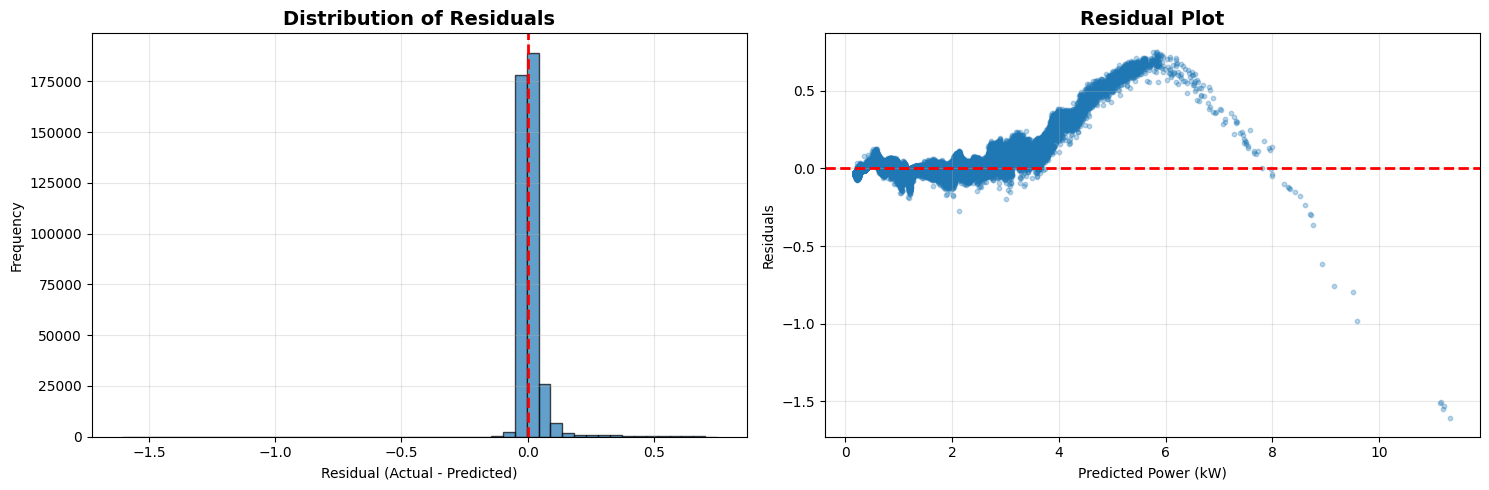

Residual Statistics:
Mean: 0.0105
Std: 0.0528
Min: -1.6088
Max: 0.7514


In [21]:
# Calculate residuals
residuals = y_test - y_pred

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Residual distribution
axes[0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0].set_title('Distribution of Residuals', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Residual (Actual - Predicted)')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

# Residual plot
axes[1].scatter(y_pred, residuals, alpha=0.3, s=10)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Power (kW)')
axes[1].set_ylabel('Residuals')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Residual Statistics:")
print(f"Mean: {residuals.mean():.4f}")
print(f"Std: {residuals.std():.4f}")
print(f"Min: {residuals.min():.4f}")
print(f"Max: {residuals.max():.4f}")

# Cell 21: Feature Importance Analysis

In [22]:
# Analyze feature importance using permutation
from sklearn.inspection import permutation_importance

print("🔍 Calculating feature importance (this may take a few minutes)...")

# Use a subset for faster computation
subset_size = 10000
X_subset = X_test_scaled[:subset_size]
y_subset = y_test[:subset_size]

# Calculate permutation importance
perm_importance = permutation_importance(
    model, X_subset, y_subset,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Create importance dataframe
importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': perm_importance.importances_mean,
    'std': perm_importance.importances_std
}).sort_values('importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 15 Most Important Features', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n=== Top 10 Most Important Features ===")
print(importance_df.head(10))

🔍 Calculating feature importance (this may take a few minutes)...


TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <Sequential name=sequential, built=True> does not.

#  Cell 22: Generate Recommendations - Helper Functions

In [24]:
# Recommendation system functions

def identify_high_consumption_periods(actual, predicted, threshold=1.2):
    """
    Identify periods where actual consumption exceeds predicted by threshold
    """
    excess = actual - predicted
    excess_pct = (actual / predicted - 1) * 100
    high_consumption = excess_pct > (threshold - 1) * 100
    return high_consumption, excess, excess_pct

def generate_recommendations(hour, day_of_week, excess_pct, sub_metering):
    """
    Generate personalized recommendations based on usage patterns
    """
    recommendations = []
    
    # Time-based recommendations
    if hour >= 18 and hour <= 22:  # Evening peak
        recommendations.append({
            'type': 'Peak Hour Usage',
            'severity': 'High' if excess_pct > 30 else 'Medium',
            'message': f'High consumption detected during evening peak hours ({hour}:00)',
            'suggestion': 'Consider shifting non-essential appliance usage to off-peak hours (23:00-06:00)'
        })
    
    if hour >= 6 and hour <= 9:  # Morning peak
        recommendations.append({
            'type': 'Morning Peak',
            'severity': 'Medium',
            'message': f'Elevated consumption during morning hours ({hour}:00)',
            'suggestion': 'Optimize heating/cooling and avoid running multiple high-power appliances simultaneously'
        })
    
    # Day of week recommendations
    if day_of_week < 5:  # Weekday
        recommendations.append({
            'type': 'Weekday Pattern',
            'severity': 'Low',
            'message': 'Higher than expected weekday consumption',
            'suggestion': 'Consider using timers for appliances and ensure devices are off when leaving home'
        })
    
    # Sub-metering based recommendations
    if sub_metering[0] > 10:  # Kitchen
        recommendations.append({
            'type': 'Kitchen Appliances',
            'severity': 'Medium',
            'message': 'High kitchen appliance usage detected',
            'suggestion': 'Use energy-efficient cooking methods, run dishwasher only when full, check refrigerator settings'
        })
    
    if sub_metering[1] > 10:  # Laundry
        recommendations.append({
            'type': 'Laundry',
            'severity': 'Medium',
            'message': 'High laundry room consumption',
            'suggestion': 'Use cold water for washing, air dry when possible, run full loads only'
        })
    
    if sub_metering[2] > 15:  # Heating/Cooling
        recommendations.append({
            'type': 'HVAC System',
            'severity': 'High',
            'message': 'High heating/cooling energy usage',
            'suggestion': 'Adjust thermostat by 2-3°C, ensure proper insulation, clean filters regularly'
        })
    
    # General recommendations based on excess percentage
    if excess_pct > 50:
        recommendations.append({
            'type': 'Critical Alert',
            'severity': 'Critical',
            'message': f'Consumption exceeds prediction by {excess_pct:.1f}%',
            'suggestion': 'Immediate action needed: Check for malfunctioning appliances or unusual usage patterns'
        })
    elif excess_pct > 30:
        recommendations.append({
            'type': 'High Usage Alert',
            'severity': 'High',
            'message': f'Consumption {excess_pct:.1f}% above expected',
            'suggestion': 'Review current appliance usage and turn off unnecessary devices'
        })
    
    return recommendations

print("✅ Recommendation functions defined")

✅ Recommendation functions defined


# Cell 23: Apply Recommendation System

In [25]:
# Apply recommendation system to test data
print("🔍 Analyzing consumption patterns and generating recommendations...")

# Prepare test data with datetime information
test_start_idx = split_idx
test_df = df.iloc[test_start_idx:test_start_idx + len(y_test)].copy()
test_df['predicted_consumption'] = y_pred
test_df['actual_consumption'] = y_test

# Identify high consumption periods
high_consumption, excess, excess_pct = identify_high_consumption_periods(
    y_test, y_pred, threshold=1.2
)

test_df['high_consumption'] = high_consumption
test_df['excess'] = excess
test_df['excess_pct'] = excess_pct

# Generate recommendations for high consumption periods
all_recommendations = []

for idx in test_df[test_df['high_consumption']].index[:100]:  # Analyze first 100 cases
    row = test_df.loc[idx]
    
    recommendations = generate_recommendations(
        hour=row['hour'],
        day_of_week=row['day_of_week'],
        excess_pct=row['excess_pct'],
        sub_metering=[row['Sub_metering_1'], row['Sub_metering_2'], row['Sub_metering_3']]
    )
    
    for rec in recommendations:
        rec['datetime'] = row['datetime']
        rec['actual'] = row['actual_consumption']
        rec['predicted'] = row['predicted_consumption']
        rec['excess_pct'] = row['excess_pct']
        all_recommendations.append(rec)

recommendations_df = pd.DataFrame(all_recommendations)

print(f"\n✅ Analysis complete!")
print(f"High consumption periods identified: {high_consumption.sum():,}")
print(f"Percentage of high consumption: {(high_consumption.sum() / len(high_consumption)) * 100:.2f}%")
print(f"Total recommendations generated: {len(recommendations_df)}")

🔍 Analyzing consumption patterns and generating recommendations...

✅ Analysis complete!
High consumption periods identified: 20
Percentage of high consumption: 0.00%
Total recommendations generated: 21


# Cell 24: Display Top Recommendations

In [29]:
# Display top recommendations by severity
severity_order = {'Critical': 4, 'High': 3, 'Medium': 2, 'Low': 1}
recommendations_df['severity_rank'] = recommendations_df['severity'].map(severity_order)
top_recommendations = recommendations_df.nlargest(20, 'severity_rank')

print("=" * 80)
print("🎯 TOP 20 ENERGY-SAVING RECOMMENDATIONS")
print("=" * 80)

for idx, row in top_recommendations.iterrows():
    print(f"\n📅 Date/Time: {row['datetime']}")
    print(f"⚡ Type: {row['type']}")
    print(f"🚨 Severity: {row['severity']}")
    print(f"📊 Excess: {row['excess_pct']:.1f}%")
    print(f"💡 Issue: {row['message']}")
    print(f"✅ Action: {row['suggestion']}")
    print("-" * 80)

# Summary by severity
print("\n=== Recommendations by Severity ===")
print(recommendations_df['severity'].value_counts().sort_index())

🎯 TOP 20 ENERGY-SAVING RECOMMENDATIONS

📅 Date/Time: 2010-02-22 06:34:00
⚡ Type: Morning Peak
🚨 Severity: Medium
📊 Excess: 20.2%
💡 Issue: Elevated consumption during morning hours (6:00)
✅ Action: Optimize heating/cooling and avoid running multiple high-power appliances simultaneously
--------------------------------------------------------------------------------

📅 Date/Time: 2010-04-05 22:05:00
⚡ Type: Peak Hour Usage
🚨 Severity: Medium
📊 Excess: 20.3%
💡 Issue: High consumption detected during evening peak hours (22:00)
✅ Action: Consider shifting non-essential appliance usage to off-peak hours (23:00-06:00)
--------------------------------------------------------------------------------

📅 Date/Time: 2010-04-10 22:22:00
⚡ Type: Peak Hour Usage
🚨 Severity: Medium
📊 Excess: 20.5%
💡 Issue: High consumption detected during evening peak hours (22:00)
✅ Action: Consider shifting non-essential appliance usage to off-peak hours (23:00-06:00)
------------------------------------------------

# Cell 25: Visualize High Consumption Patterns

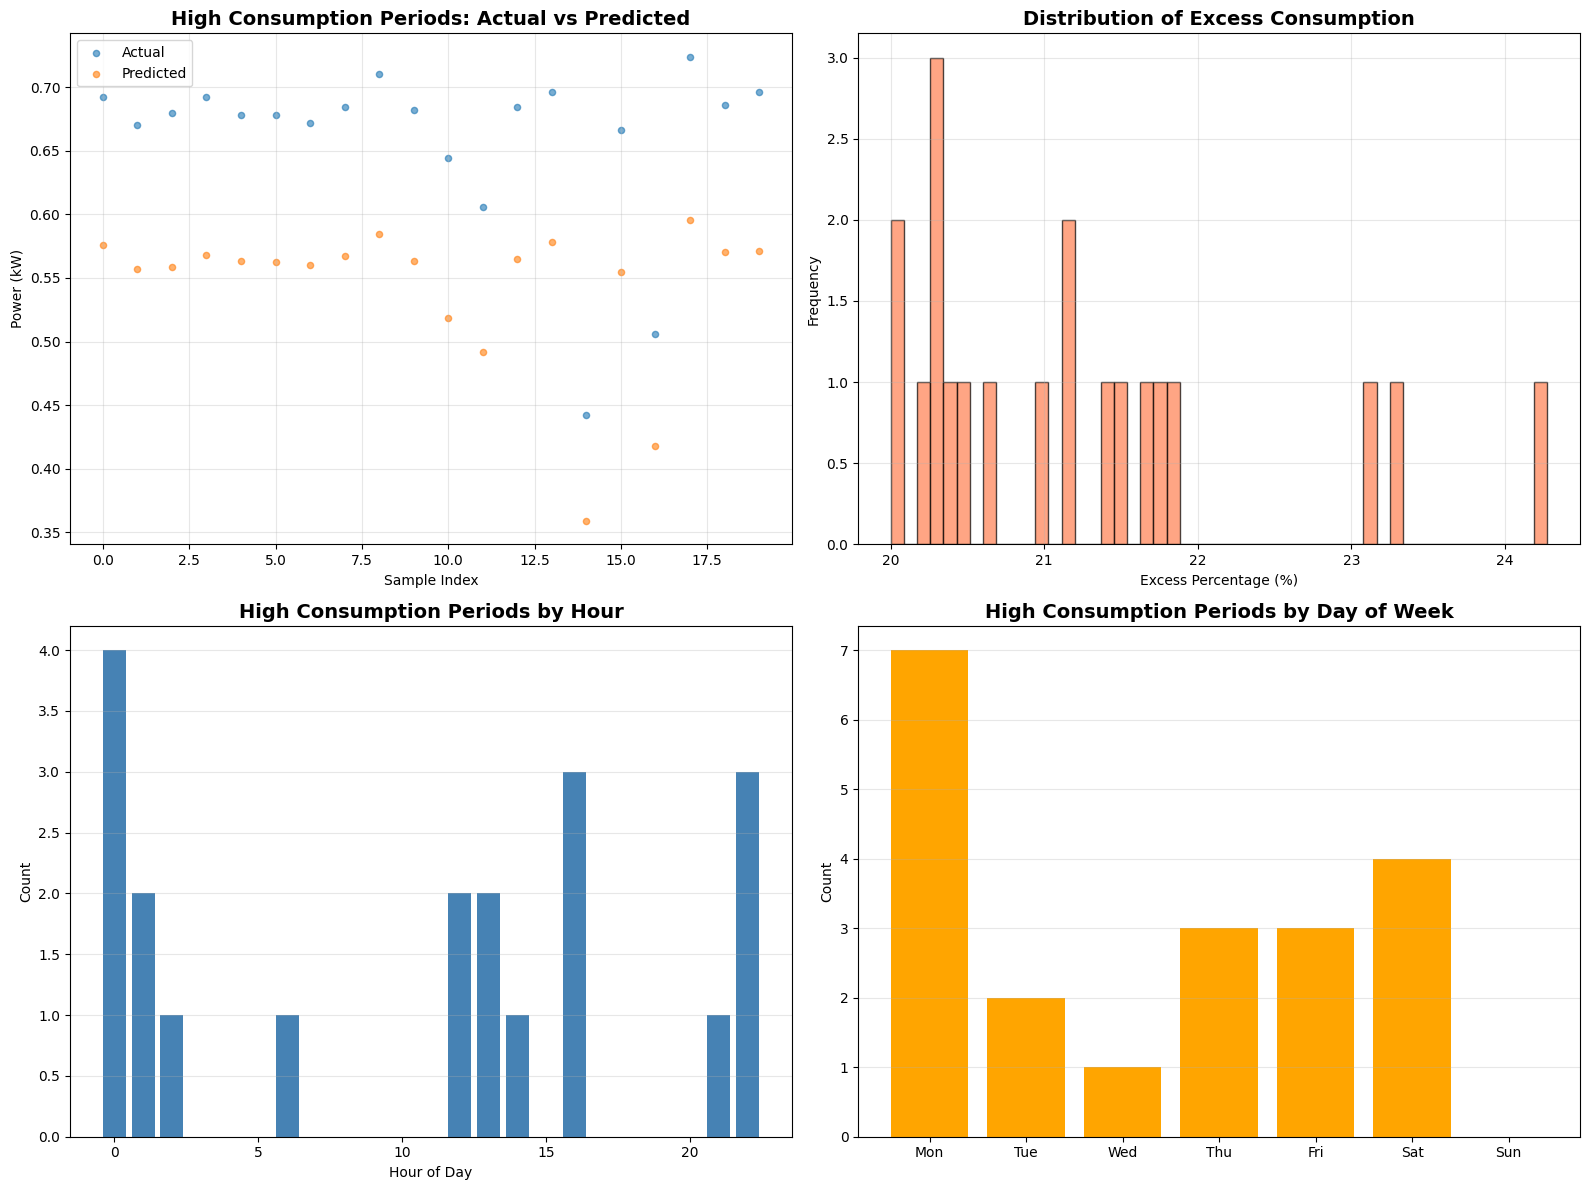

In [30]:
# Visualize high consumption periods
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. High consumption over time
high_cons_df = test_df[test_df['high_consumption']]
sample = high_cons_df.head(500)

axes[0, 0].scatter(range(len(sample)), sample['actual_consumption'], 
                   alpha=0.6, label='Actual', s=20)
axes[0, 0].scatter(range(len(sample)), sample['predicted_consumption'], 
                   alpha=0.6, label='Predicted', s=20)
axes[0, 0].set_title('High Consumption Periods: Actual vs Predicted', 
                      fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Sample Index')
axes[0, 0].set_ylabel('Power (kW)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Distribution of excess percentage
axes[0, 1].hist(test_df[test_df['high_consumption']]['excess_pct'], 
                bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].set_title('Distribution of Excess Consumption', 
                      fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Excess Percentage (%)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# 3. High consumption by hour
high_by_hour = high_cons_df.groupby('hour').size()
axes[1, 0].bar(high_by_hour.index, high_by_hour.values, color='steelblue')
axes[1, 0].set_title('High Consumption Periods by Hour', 
                      fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Count')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. High consumption by day of week
high_by_day = high_cons_df.groupby('day_of_week').size()
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1, 1].bar(range(7), [high_by_day.get(i, 0) for i in range(7)], 
               color='orange')
axes[1, 1].set_xticks(range(7))
axes[1, 1].set_xticklabels(day_names)
axes[1, 1].set_title('High Consumption Periods by Day of Week', 
                      fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Count')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Cell 26: Recommendation Summary Dashboard

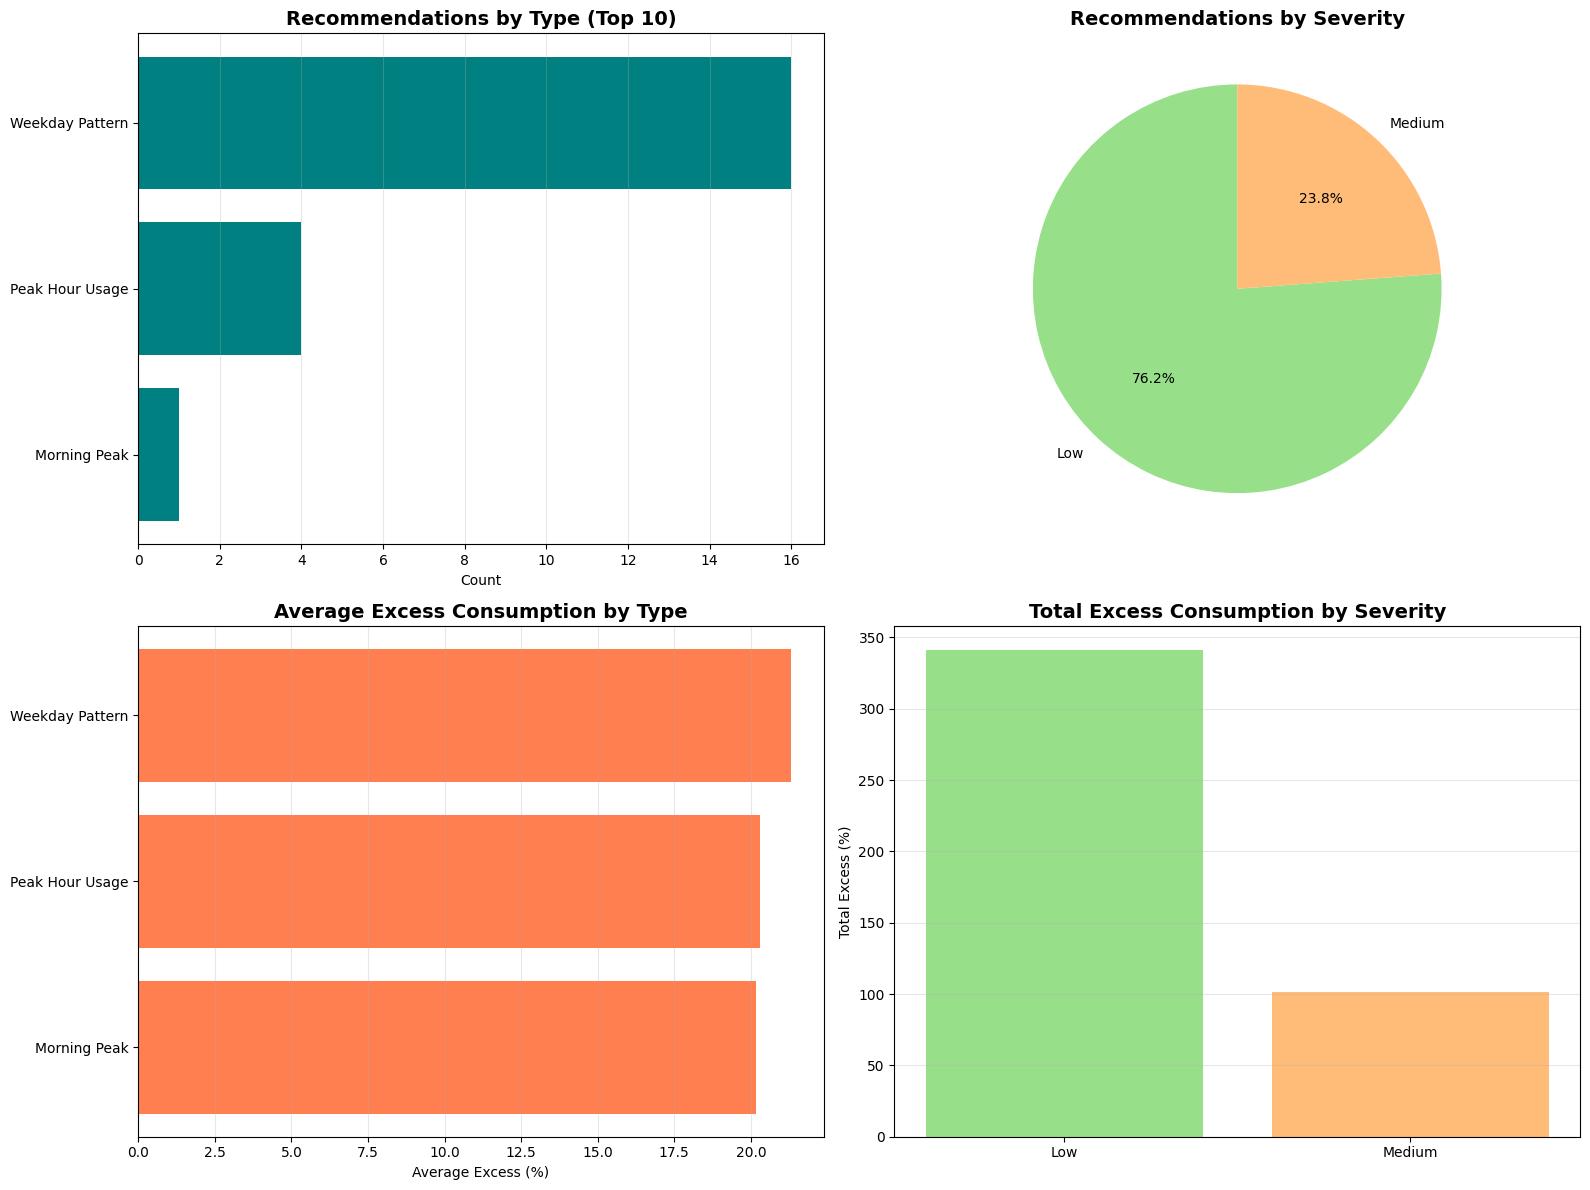

In [31]:
# Create recommendation summary
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Recommendations by type
rec_by_type = recommendations_df['type'].value_counts().head(10)
axes[0, 0].barh(range(len(rec_by_type)), rec_by_type.values, color='teal')
axes[0, 0].set_yticks(range(len(rec_by_type)))
axes[0, 0].set_yticklabels(rec_by_type.index, fontsize=10)
axes[0, 0].set_title('Recommendations by Type (Top 10)', 
                      fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Count')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(True, alpha=0.3, axis='x')

# 2. Recommendations by severity
severity_counts = recommendations_df['severity'].value_counts()
colors_severity = {'Critical': '#d62728', 'High': '#ff7f0e', 
                   'Medium': '#ffbb78', 'Low': '#98df8a'}
axes[0, 1].pie(severity_counts.values, labels=severity_counts.index, 
               autopct='%1.1f%%', startangle=90,
               colors=[colors_severity.get(x, 'gray') for x in severity_counts.index])
axes[0, 1].set_title('Recommendations by Severity', 
                      fontsize=14, fontweight='bold')

# 3. Average excess by recommendation type
avg_excess = recommendations_df.groupby('type')['excess_pct'].mean().sort_values(ascending=False).head(10)
axes[1, 0].barh(range(len(avg_excess)), avg_excess.values, color='coral')
axes[1, 0].set_yticks(range(len(avg_excess)))
axes[1, 0].set_yticklabels(avg_excess.index, fontsize=10)
axes[1, 0].set_title('Average Excess Consumption by Type', 
                      fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Average Excess (%)')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3, axis='x')

# 4. Potential savings by severity
savings_by_severity = recommendations_df.groupby('severity')['excess_pct'].sum()
axes[1, 1].bar(range(len(savings_by_severity)), savings_by_severity.values,
               color=[colors_severity.get(x, 'gray') for x in savings_by_severity.index])
axes[1, 1].set_xticks(range(len(savings_by_severity)))
axes[1, 1].set_xticklabels(savings_by_severity.index)
axes[1, 1].set_title('Total Excess Consumption by Severity', 
                      fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Total Excess (%)')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

#  Cell 27: Calculate Potential Cost Savings

💰 POTENTIAL COST SAVINGS ANALYSIS

📊 Consumption Analysis (Test Period: 17077.2 days)
   Total Actual Consumption: 416,552.21 kWh
   Total Predicted (Normal) Consumption: 412,252.19 kWh
   Total Excess Consumption: 4,300.02 kWh

💵 Cost Analysis (Rate: $0.12/kWh)
   Current Cost: $49,986.26
   Optimal Cost (Predicted): $49,470.26
   Excess Cost: $516.00

✨ Potential Savings (30% reduction in excess)
   Energy Savings: 1,290.01 kWh
   Cost Savings: $154.80

📈 Annual Projections
   Annual Excess Cost: $11.03
   Annual Potential Savings: $3.31
   Percentage Reduction: 0.31%


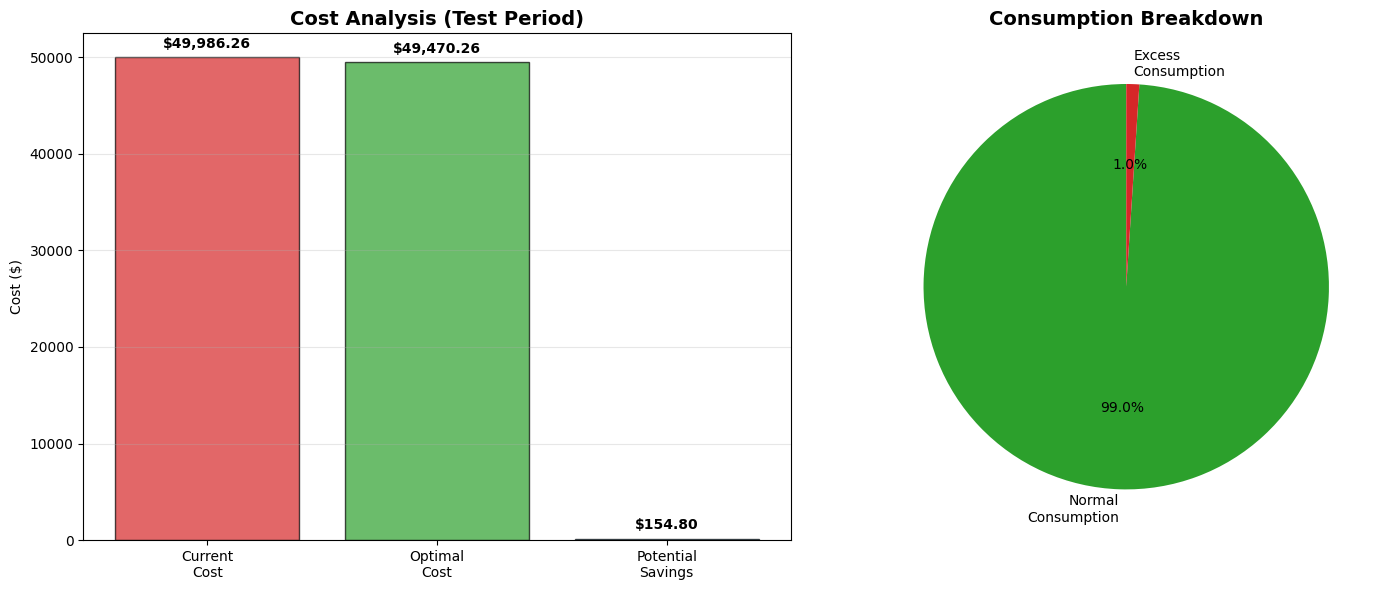

In [32]:
# Calculate potential cost savings
print("=" * 80)
print("💰 POTENTIAL COST SAVINGS ANALYSIS")
print("=" * 80)

# Assumptions
avg_electricity_rate = 0.12  # $/kWh (adjust based on your location)
days_in_test = len(test_df) / 24  # Convert hours to days

# Calculate current costs
total_actual_consumption = test_df['actual_consumption'].sum()
total_predicted_consumption = test_df['predicted_consumption'].sum()
total_excess_consumption = total_actual_consumption - total_predicted_consumption

current_cost = total_actual_consumption * avg_electricity_rate
predicted_cost = total_predicted_consumption * avg_electricity_rate
excess_cost = total_excess_consumption * avg_electricity_rate

print(f"\n📊 Consumption Analysis (Test Period: {days_in_test:.1f} days)")
print(f"   Total Actual Consumption: {total_actual_consumption:,.2f} kWh")
print(f"   Total Predicted (Normal) Consumption: {total_predicted_consumption:,.2f} kWh")
print(f"   Total Excess Consumption: {total_excess_consumption:,.2f} kWh")

print(f"\n💵 Cost Analysis (Rate: ${avg_electricity_rate}/kWh)")
print(f"   Current Cost: ${current_cost:,.2f}")
print(f"   Optimal Cost (Predicted): ${predicted_cost:,.2f}")
print(f"   Excess Cost: ${excess_cost:,.2f}")

# Calculate potential savings with recommendations
# Assume 30% reduction in excess consumption if recommendations are followed
reduction_rate = 0.30
potential_savings_kwh = total_excess_consumption * reduction_rate
potential_savings_cost = potential_savings_kwh * avg_electricity_rate

print(f"\n✨ Potential Savings (30% reduction in excess)")
print(f"   Energy Savings: {potential_savings_kwh:,.2f} kWh")
print(f"   Cost Savings: ${potential_savings_cost:,.2f}")

# Annualized projections
days_in_year = 365
annual_factor = days_in_year / days_in_test

annual_excess_cost = excess_cost * annual_factor
annual_potential_savings = potential_savings_cost * annual_factor

print(f"\n📈 Annual Projections")
print(f"   Annual Excess Cost: ${annual_excess_cost:,.2f}")
print(f"   Annual Potential Savings: ${annual_potential_savings:,.2f}")
print(f"   Percentage Reduction: {(potential_savings_cost/current_cost)*100:.2f}%")

print("=" * 80)

# Visualize savings
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart of costs
costs = ['Current\nCost', 'Optimal\nCost', 'Potential\nSavings']
values = [current_cost, predicted_cost, potential_savings_cost]
colors_cost = ['#d62728', '#2ca02c', '#1f77b4']

axes[0].bar(costs, values, color=colors_cost, alpha=0.7, edgecolor='black')
axes[0].set_title('Cost Analysis (Test Period)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Cost ($)')
axes[0].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(values):
    axes[0].text(i, v + max(values)*0.02, f'${v:,.2f}', 
                ha='center', fontweight='bold')

# Pie chart of consumption breakdown
consumption_labels = ['Normal\nConsumption', 'Excess\nConsumption']
consumption_values = [total_predicted_consumption, total_excess_consumption]
consumption_colors = ['#2ca02c', '#d62728']

axes[1].pie(consumption_values, labels=consumption_labels, autopct='%1.1f%%',
           colors=consumption_colors, startangle=90)
axes[1].set_title('Consumption Breakdown', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Cell 28: Save Model and Scalers for Production

In [34]:
import os
import joblib
import json
import pandas as pd
from datetime import datetime

# Create a directory for saved models
model_dir = 'electricity_prediction_model'
os.makedirs(model_dir, exist_ok=True)

print("💾 Saving model and artifacts for production...")

# 1. Save the Keras model (Keras 3 format)
model_path = f'{model_dir}/neural_network_model.keras'
model.save(model_path)
print(f"✅ Model saved (Keras format): {model_path}")

# 2. Export TensorFlow SavedModel (for production / TF Serving)
saved_model_path = f'{model_dir}/saved_model'
model.export(saved_model_path)
print(f"✅ TensorFlow SavedModel exported: {saved_model_path}")

# 3. Save scalers
scaler_X_path = f'{model_dir}/scaler_X.pkl'
scaler_y_path = f'{model_dir}/scaler_y.pkl'
joblib.dump(scaler_X, scaler_X_path)
joblib.dump(scaler_y, scaler_y_path)
print(f"✅ Scalers saved: {scaler_X_path}, {scaler_y_path}")

# 4. Save feature names and info
feature_info = {
    'feature_names': feature_columns,
    'n_features': len(feature_columns),
    'target_name': target_column
}
feature_path = f'{model_dir}/feature_info.json'
with open(feature_path, 'w') as f:
    json.dump(feature_info, f, indent=2)
print(f"✅ Feature info saved: {feature_path}")

# 5. Save model metadata
metadata = {
    'model_type': 'Neural Network (MLP)',
    'framework': 'TensorFlow/Keras',
    'created_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'metrics': {
        'mse': float(mse),
        'rmse': float(rmse),
        'mae': float(mae),
        'r2_score': float(r2),
        'mape': float(mape)
    },
    'model_architecture': {
        'layers': [
            {'type': 'Dense', 'units': 128, 'activation': 'relu'},
            {'type': 'BatchNormalization'},
            {'type': 'Dropout', 'rate': 0.3},
            {'type': 'Dense', 'units': 64, 'activation': 'relu'},
            {'type': 'BatchNormalization'},
            {'type': 'Dropout', 'rate': 0.2},
            {'type': 'Dense', 'units': 32, 'activation': 'relu'},
            {'type': 'BatchNormalization'},
            {'type': 'Dropout', 'rate': 0.2},
            {'type': 'Dense', 'units': 16, 'activation': 'relu'},
            {'type': 'Dense', 'units': 1}
        ],
        'optimizer': 'Adam',
        'learning_rate': 0.001,
        'loss': 'mse'
    },
    'hyperparameters': {
        'epochs': len(history.history['loss']),
        'batch_size': 128,
        'validation_split': 0.2
    }
}

metadata_path = f'{model_dir}/model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✅ Model metadata saved: {metadata_path}")

# 6. Save training history
history_df = pd.DataFrame(history.history)
history_path = f'{model_dir}/training_history.csv'
history_df.to_csv(history_path, index=False)
print(f"✅ Training history saved: {history_path}")

print("\n" + "=" * 80)
print("📦 All model artifacts saved successfully!")
print("=" * 80)
print(f"\nModel directory: {model_dir}/")
print("Contents:")
print("  - neural_network_model.keras (Keras 3 format)")
print("  - saved_model/ (TensorFlow SavedModel export)")
print("  - scaler_X.pkl (Feature scaler)")
print("  - scaler_y.pkl (Target scaler)")
print("  - feature_info.json (Feature names and metadata)")
print("  - model_metadata.json (Model info and performance)")
print("  - training_history.csv (Training history)")


💾 Saving model and artifacts for production...
✅ Model saved (Keras format): electricity_prediction_model/neural_network_model.keras
INFO:tensorflow:Assets written to: electricity_prediction_model/saved_model/assets


INFO:tensorflow:Assets written to: electricity_prediction_model/saved_model/assets


Saved artifact at 'electricity_prediction_model/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 25), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139031969664464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139031969664848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139031969666384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139031969666192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139031969666768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139031969664656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139031969665808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139031969667728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139031969668112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139031969666576: TensorSpec(shape=(), dtype=tf.resource, name=None)
 

# Cell 29: Download Trained Model

In [35]:
import shutil
from IPython.display import FileLink

# 1️⃣ Define your model directory and output zip path
model_dir = 'electricity_prediction_model'
zip_path = f'{model_dir}.zip'

# 2️⃣ Create a zip archive of the folder
shutil.make_archive(base_name=model_dir, format='zip', root_dir=model_dir)
print(f"✅ Folder zipped successfully: {zip_path}")

# 3️⃣ Provide a download link in the notebook
FileLink(zip_path)


✅ Folder zipped successfully: electricity_prediction_model.zip


/kaggle/working/electricity_prediction_model.zip